# Mini Project - Molecules
-------------
Aim to classify molecules into hydrocarbon, amine or alcohol
- The models presented in this notebook were trained using the input features outlined in the report

In [1]:
#imports
#general----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#PCA----------------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#kmeans-------------------------------
from sklearn.cluster import KMeans
#PCR----------------------------------
from sklearn.linear_model import LinearRegression
#resample----------------------------
from imblearn.over_sampling import SMOTE
from collections import Counter
#KNN---------------------------------
from sklearn.neighbors import KNeighborsClassifier
#sci-kit learn------------------------
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
#stats linear reg---------------------
import statsmodels.api as sm
from statsmodels.formula.api import logit
#DecisionTre--------------------------
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [2]:
mol_df = pd.read_csv('molecules.csv')
classify = mol_df['Classify1'].to_list()

mol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cmpdname            1748 non-null   object 
 1   BoilingPoint        1748 non-null   float64
 2   mw                  1748 non-null   float64
 3   polararea           1748 non-null   float64
 4   heavycnt            1748 non-null   int64  
 5   hbondacc            1748 non-null   int64  
 6   C number            1748 non-null   int64  
 7   N number            1748 non-null   int64  
 8   O number            1748 non-null   int64  
 9   Side chain number   1748 non-null   int64  
 10  Double bond number  1748 non-null   int64  
 11  Triple bond number  1748 non-null   int64  
 12  Classify1           1748 non-null   object 
dtypes: float64(3), int64(8), object(2)
memory usage: 177.7+ KB


Datatypes:
-  Continuous: BoilingPoint, mw, polararea, 
-  Discrete: heavycnt, hbondacc, C number, N number, O number, Side chain number, Double bond number, Triple bond number

In [3]:
mol_df.groupby(by='Classify1').mean()

,BoilingPoint,mw,polararea,heavycnt,hbondacc,C number,N number,O number,Side chain number,Double bond number,Triple bond number
Classify1,,,,,,,,,,,
Alcohol,500.405267,147.721604,27.925733,10.241042,1.491857,8.749186,0.00000,1.491857,1.682410,0.289902,0.074919
Amine,452.104173,155.057568,18.483044,10.836066,1.316940,9.519126,1.31694,0.000000,1.136612,0.081967,0.021858
Hydrocarbon,465.583837,167.637361,0.000000,11.922187,0.000000,11.919033,0.00000,0.000000,1.588854,0.554154,0.121977


Further analysis in report. 

In [4]:
import seaborn as sns
variables=['BoilingPoint', 'mw','polararea','heavycnt','hbondacc','C number','N number','O number','Side chain number','Double bond number','Triple bond number']

#uncomment to view histograms and box plots for each input var.
# for var in variables:
#     #plot histogram
#     sns.displot(data=mol_df, x=f"{var}", col="Classify1")

#     #Plot boxplots
#     sns.catplot(data=mol_df,x="Classify1",y=f"{var}", palette=['tab:orange','tab:blue','tab:green'], kind="box");

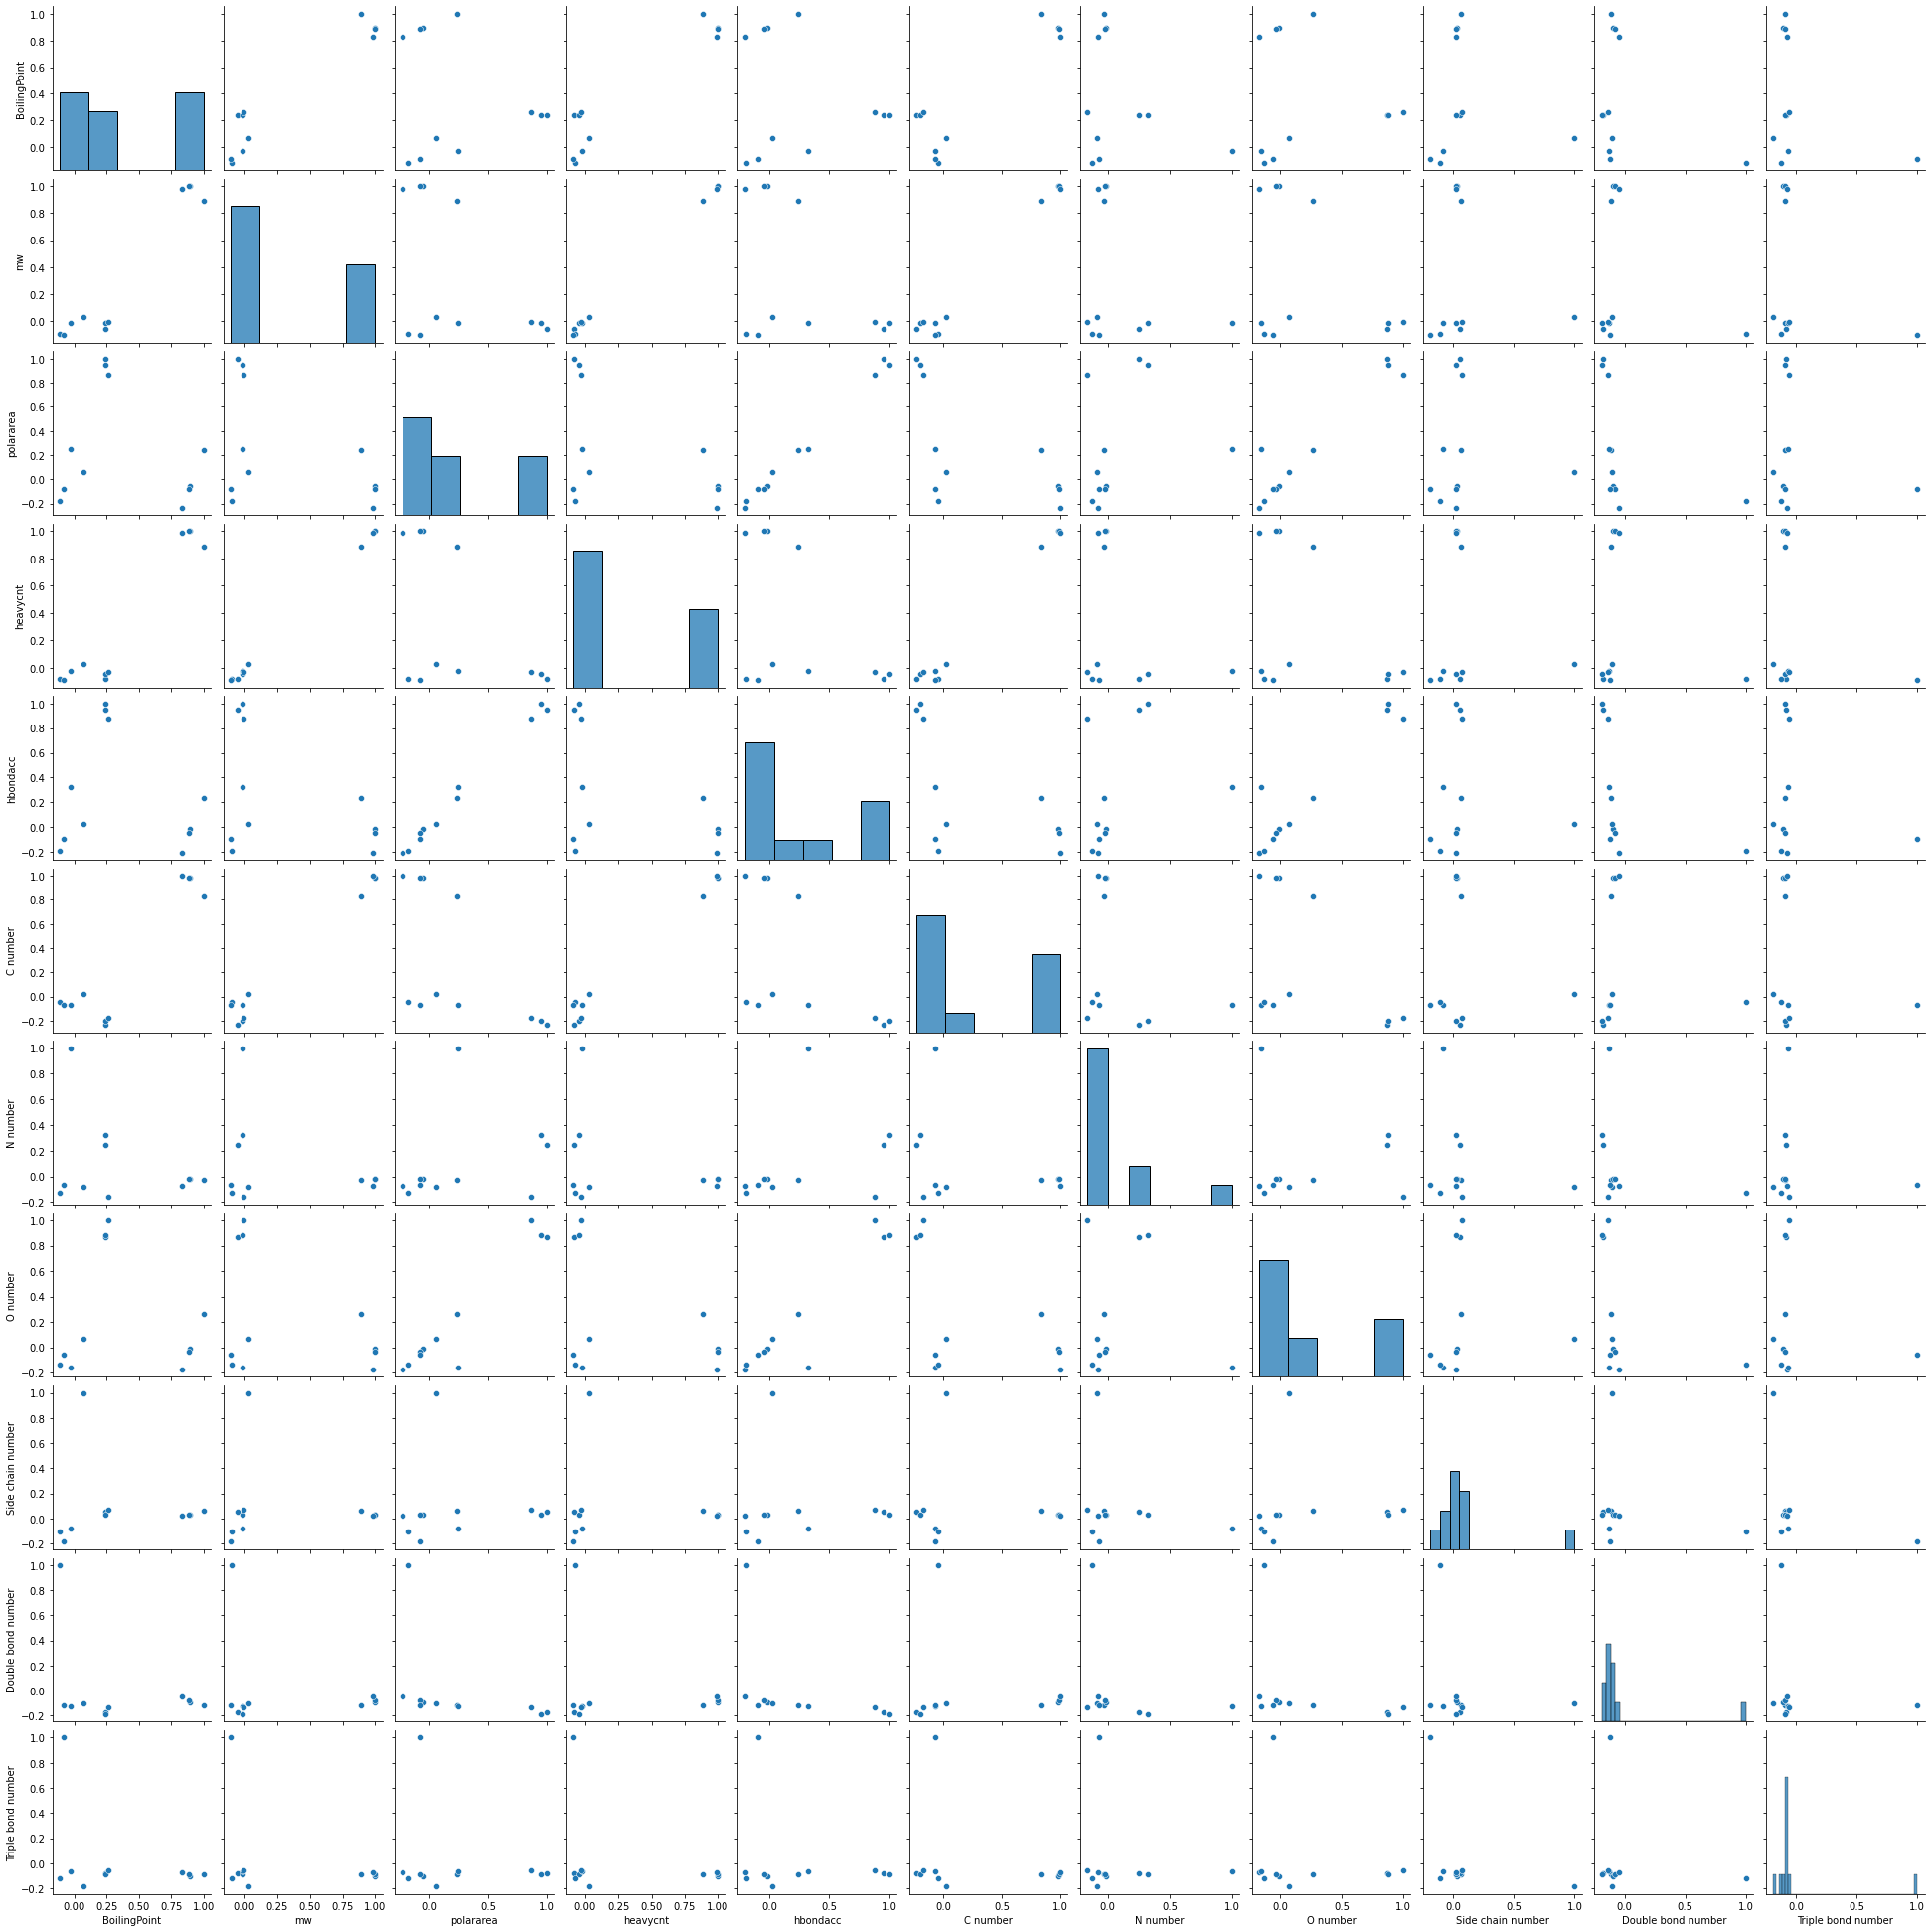

In [5]:
sns.pairplot(mol_df.corr())

<AxesSubplot:>

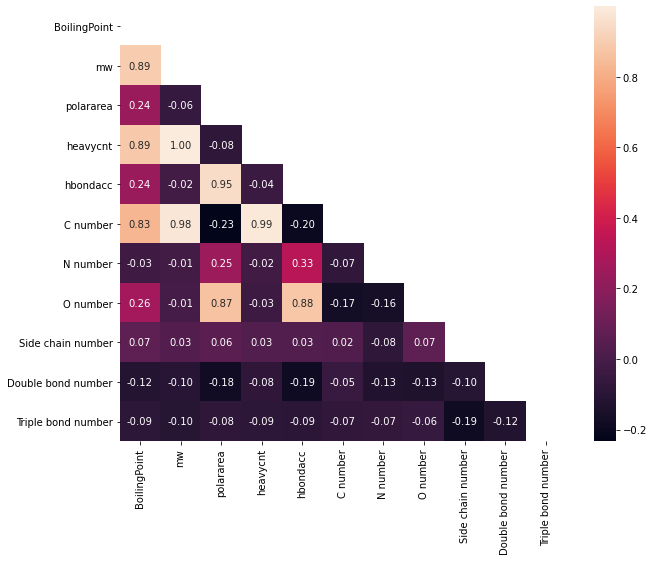

In [6]:
plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(mol_df.corr(), dtype=bool))
sns.heatmap(mol_df.corr(), mask=mask, annot=True, fmt=".2f")

In [7]:
#further investiagte highly correlated variables
mol_df[['mw','heavycnt','C number','BoilingPoint']].corr()

,mw,heavycnt,C number,BoilingPoint
mw,1.000000,0.999388,0.982003,0.893670
heavycnt,0.999388,1.000000,0.986881,0.886767
C number,0.982003,0.986881,1.000000,0.830568
BoilingPoint,0.893670,0.886767,0.830568,1.000000


In [8]:
#further investigate highly correlated variables
mol_df[['hbondacc','polararea','O number']].corr() 

,hbondacc,polararea,O number
hbondacc,1.000000,0.950083,0.880079
polararea,0.950083,1.000000,0.867561
O number,0.880079,0.867561,1.000000


In [9]:
#investigate the balance of class labels
mol_df['Classify1'].value_counts()

Hydrocarbon    951
Alcohol        614
Amine          183
Name: Classify1, dtype: int64

Evidently the data is very imbalanced - SMOTE resample necessary

In [10]:
#RESAMPLE (all variables included in the X variable for now)
counter = Counter(mol_df['Classify1'])
smt = SMOTE()
X = mol_df[['BoilingPoint','mw','polararea','heavycnt','hbondacc','C number','N number','O number','Side chain number','Double bond number','Triple bond number']]
X_sm, y_sm = smt.fit_resample(X, mol_df['Classify1'])
pca_df_sm = X_sm.copy()

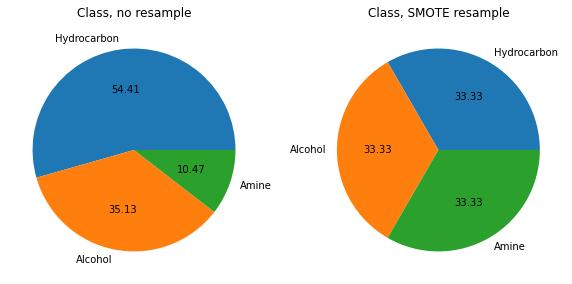

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))

ax1.pie(mol_df['Classify1'].value_counts(), labels=['Hydrocarbon', 'Alcohol', 'Amine'], autopct='%.2f')
ax2.pie(y_sm.value_counts(), labels=['Hydrocarbon', 'Alcohol', 'Amine'], autopct='%.2f')

ax1.set(title='Class, no resample')
ax2.set(title='Class, SMOTE resample');

In [12]:
X_compare_sm = X_sm.join(y_sm).groupby(by='Classify1').mean()
X_compare_sm

,BoilingPoint,mw,polararea,heavycnt,hbondacc,C number,N number,O number,Side chain number,Double bond number,Triple bond number
Classify1,,,,,,,,,,,
Alcohol,499.470812,147.578949,27.268183,10.208202,1.435331,8.748686,0.000000,1.435331,1.601472,0.248160,0.054679
Amine,448.425683,152.651089,18.180549,10.460568,1.187171,9.136698,1.187171,0.000000,0.896951,0.048370,0.006309
Hydrocarbon,465.583837,167.637361,0.000000,11.922187,0.000000,11.919033,0.000000,0.000000,1.588854,0.554154,0.121977


# PCA and KMeans Analysis

In [13]:
#colour list based on molecule classification
colour_list = []
for i in mol_df['Classify1']:
    if i =='Hydrocarbon':
        colour_list.append(0)
    elif i =='Alcohol':
        colour_list.append(1)
    else:
        colour_list.append(2)

#pca------------------------------------------
#drop unecessary cols
pca_df = mol_df.drop(['Classify1', 'cmpdname'], axis=1)

#scale dataframe
scaled_df = StandardScaler().fit_transform(pca_df)

#do the principle component analysis
n=len(pca_df.axes[1]) #i.e. n=total num of input features
pca = PCA(n_components = n)

#apply the dimensionality reduction onto the data
pca_data = pca.fit_transform(scaled_df)

#kmeans----------------------------------------
kmeans = KMeans(n_clusters=3, init = 'random', max_iter = 5, random_state = 5)
kmeans.fit(pca_data)
labels_km = kmeans.predict(pca_data) # i.e. the predictions from the k means model

C:\Users\grclo\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,BoilingPoint,mw,polararea,heavycnt,hbondacc,C number,N number,O number,Side chain number,Double bond number,Triple bond number
0,470.65,62.070,40.5,4,2,2,0,2,1,0,0
1,455.15,90.120,40.5,6,2,4,0,2,2,0,0
2,390.75,74.120,20.2,5,1,4,0,1,0,0,0
3,111.65,16.043,0.0,1,0,1,0,0,0,0,0
4,398.77,114.230,0.0,8,0,8,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1743,413.15,124.220,0.0,9,0,9,0,0,2,2,0
1744,460.65,158.280,20.2,11,1,10,0,1,5,0,0
1745,471.15,130.229,20.2,9,1,8,0,1,3,0,0
1746,437.90,130.229,20.2,9,1,8,0,1,4,0,0


## 2D PCA and PCA/KMeans Visualisation

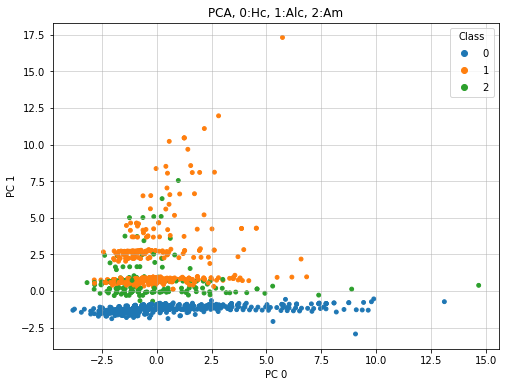

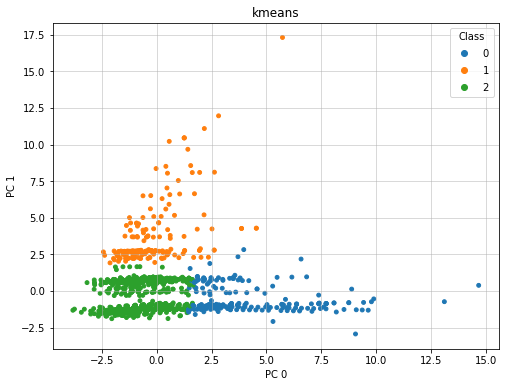

In [14]:
import matplotlib
colours=['tab:blue','tab:orange','tab:green']
cmap=matplotlib.colors.ListedColormap(colours)

#plot the data
fig, ax = plt.subplots(figsize=(8,6))

scat = ax.scatter(x = pca_data[:, 0], y = pca_data[:, 1], s = 15, c=colour_list, cmap=cmap)

#title
ax.set(title = "PCA, 0:Hc, 1:Alc, 2:Am", xlabel = "PC 0", ylabel = "PC 1")
ax.legend(*scat.legend_elements(), title='Class')
ax.grid(alpha=0.6);

#---------------------------------------------------------

fig,ax2 = plt.subplots(figsize=(8,6))

scat2 = ax2.scatter(pca_data[:, 0], pca_data[:, 1], s=15, c=labels_km, cmap=cmap)

ax2.set(title = "kmeans", xlabel = "PC 0", ylabel = "PC 1")
ax2.legend(*scat2.legend_elements(), title='Class')
ax2.grid(alpha=0.6);

## 3D PCA and PCA/KMeans Visualisation

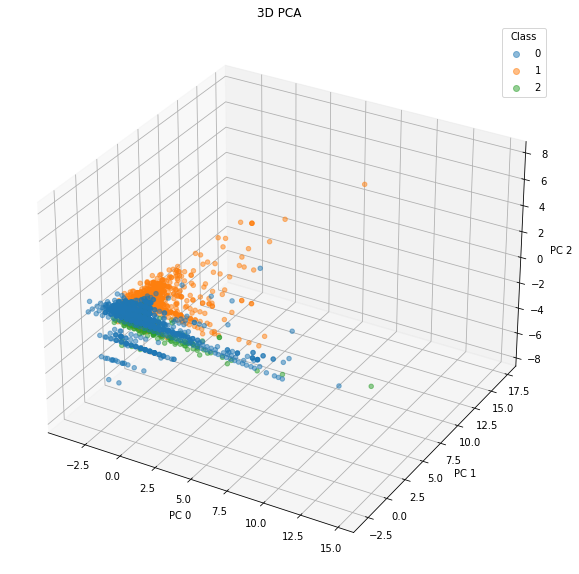

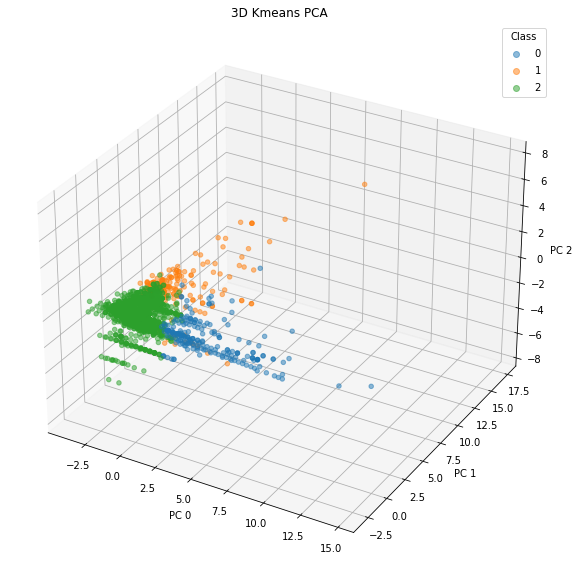

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Create fig and 3D subplot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#labels
scat = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], alpha=0.5, c=colour_list, cmap=cmap)

#titles and viewing angle
ax.set(title="3D PCA", xlabel="PC 0", ylabel="PC 1", zlabel="PC 2")
#ax.view_init(elev=15, azim=90)  
ax.legend(*scat.legend_elements(), title='Class');
#----------------------------------------------------------------

# Create fig and 3D subplot
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(111, projection='3d')

scat2 = ax2.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], alpha=0.5, c=labels_km, cmap=cmap)

#titles and viewing angle
ax2.set(title="3D Kmeans PCA", xlabel="PC 0", ylabel="PC 1", zlabel="PC 2")
#ax2.view_init(elev=15, azim=90)
ax2.legend(*scat.legend_elements(), title='Class');

In [16]:
variances = pca.explained_variance_ratio_
ind_var = variances.tolist()
individual_var = [i*100 for i in ind_var]

# Calculate the cumulative explained variance
cum_var = np.cumsum(individual_var)

pd.DataFrame({'PC':np.arange(1,n+1,1), 'Individual Variance / %': individual_var, 'Cumulative variance / %': cum_var})

,PC,Individual Variance / %,Cumulative variance / %
0,1,3.471756e+01,34.717557
1,2,2.733910e+01,62.056656
2,3,1.095436e+01,73.011013
3,4,1.021696e+01,83.227975
4,5,9.508444e+00,92.736419
5,6,5.916732e+00,98.653151
6,7,9.137066e-01,99.566858
7,8,4.328847e-01,99.999743
8,9,2.439104e-04,99.999987
9,10,1.345954e-05,100.000000


In [17]:
# feature names
feature_names = pca_df.columns

#second dataframe which includes descriptors for each PC with loadings above 0.3
df2 = pd.DataFrame({'features': feature_names, 'PC1': np.abs(pca.components_[0]), 'PC2': np.abs(pca.components_[1]), 'PC3': np.abs(pca.components_[2])})
#filter out values below 0.3
df2[['PC1','PC2','PC3']] = df2[['PC1','PC2','PC3']].apply(lambda x: np.where(x < 0.3, np.nan, x))
df2

,features,PC1,PC2,PC3
0,BoilingPoint,0.470783,NaN,NaN
1,mw,0.509371,NaN,NaN
2,polararea,NaN,0.562185,NaN
3,heavycnt,0.508889,NaN,NaN
4,hbondacc,NaN,0.566778,NaN
5,C number,0.500833,NaN,NaN
6,N number,NaN,NaN,0.539485
7,O number,NaN,0.526138,NaN
8,Side chain number,NaN,NaN,0.543878
9,Double bond number,NaN,NaN,0.339255


# -------------------------------------------------------------------------------------------------------------
# Functions used for fitting and evaluating models:
- fit_predict
- sk_eval
- blr_fit
- blr_eval

In [18]:
#design a function to fit the model on the training data, and make predictions
def fit_predict(model, trainX, trainy, testX):
    '''
    Fit the sci-kit learn model to the training data build predictions based on test data
    --------
    Inputs:
        model:
        trainX:
        trainY:
        testX:
    -------
    Outputs:
        predictions:
    '''
    model.fit(trainX, trainy)
    return model.predict(testX)

In [19]:
#def model evaluation fucntion for all sci-kit learn models
def sk_eval(y_test, y_pred):
    '''
    Function which prints and presents different model evaluation metrics
    --------
    Inputs:
        y_test:
        y_pred:
    -------
    Outputs:
        Classification report:
        Accuracy score:
        Confusion matrix:
    '''
    
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('-------------------------')
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print('-------------------------')
    print('Confusion Matrix:')
    
    return confusion_matrix(y_test, y_pred)

In [20]:
#copy data set to new name, so that we can add binary variable col later
mol= mol_df.copy()

#statsmodels BLR model
def blr_fit(binary, features, trial_eq_features, df=mol):
    '''
    Function, which based on the given binary condition, fits a statsmodels BLR.
    ---------
    Inputs:
        binary:
        df: default='mol', data from which to fit the model
    ---------
    Outputs:
        model:
        test_data:
    '''
    #input features
    X=features
    y=df[f'{binary}']
    
    #split into train and test
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.40, random_state = 10)
    
    #Only resample training set
    trainX_sm, trainY_sm = smt.fit_resample(trainX, trainY)
    
    
    #Fitting a logistic regression 
    trial_eq = (f'{binary} ~ {trial_eq_features}')
    model = logit(formula=trial_eq, data=pd.concat([trainX, trainY], axis=1)).fit()
    
    model_sm = logit(formula=trial_eq, data=pd.concat([trainX_sm, trainY_sm], axis=1)).fit()
    
    return model, model_sm, pd.concat([testX, testY],axis=1)

In [21]:
def blr_eval(model, test_data, binary, f1_only=False):
    '''
    Function which prints and presents different model evaluation metrics
    --------
    Inputs:
        model:
        test_data:
        binary:
    -------
    Outputs:
        Parameters:
        Accuracy score:
        Confusion matrix:
    '''    
    # Model evaluation on Test data set

    #Compute prediction
    prediction = model.predict(exog=test_data)
    
    #Define the cutoff
    cutoff = 0.50 
    
    #Compute class predictions: y_prediction 
    y_prediction = np.where(prediction>cutoff, 1, 0)

    #Assign actual class labels from the test sample to y_actual
    y_actual = test_data[binary]
    
    if f1_only == False:
        #Print parameters
        print(np.exp(model.params))
        print("-----------------")
        
        #----------------------------------------

        #Classification accuracy
        acc = accuracy_score(y_actual, y_prediction)
        print(f"Accuracy score: {acc}")
        print("-----------------")

        #-----------------------------------------

        #f1-score
        f1 = f1_score(y_actual, y_prediction)
        print(f'f1-score: {f1}')
        print('----------------')

        #---------------------------------
        #classification report
        print('Classification report:')
        print(classification_report(y_actual, y_prediction))
        print('-------------------------')
        
        #-----------------------------------------
        print('Confusion Matrix:')
        #output conf mat
        return confusion_matrix(y_actual,y_prediction)
    
    else:
        return f1_score(y_actual, y_prediction)

End of functions.
# ------------------------------------------------------------------------------------------------------------

# Set up models:
- Choose input variables
- Split into train/test sets
- SMOTE resample the training data
- initialise models

Note: other models which could have been used: randomforestclassifier and also SVM

In [22]:
#predictor and predicted variables
X = mol_df.drop(['cmpdname', 'Classify1', 'O number', 'BoilingPoint', 'mw', 'heavycnt', 'hbondacc', 'C number','Side chain number', 'Double bond number', 'Triple bond number'], axis=1)
y = mol_df['Classify1']

#train test
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.4, random_state=10)

#SMOTE resample train 
trainX_sm, trainY_sm = smt.fit_resample(trainX, trainY)  #train_test_split(X_smo, test_size=0.4, random_state=10)

#initialise models
model = { 'model_knn' : KNeighborsClassifier(),
          'model_dt' : DecisionTreeClassifier(splitter='best')
         }
cols = X.columns

### Quick glance at performance of each model

In [23]:
#analysis for each model at a glance, with and without re-sampling
print(f'USING {cols}')

for name, model_i in model.items():
    predY = fit_predict(model_i, trainX, trainY, testX)
    print(f'accuracy score for {name}: {accuracy_score(testY, predY) :.3f}')

print('-----------------------')

for name, model_i in model.items():
    predY_sm = fit_predict(model_i, trainX_sm, trainY_sm, testX)
    print(f'(smote data) accuracy score for {name}: {accuracy_score(testY, predY_sm) :.3f}')

USING Index(['polararea', 'N number'], dtype='object')
accuracy score for model_knn: 0.994
accuracy score for model_dt: 1.000
-----------------------
(smote data) accuracy score for model_knn: 0.991
(smote data) accuracy score for model_dt: 1.000


# KNN

In [24]:
y_pred_knn = fit_predict(model['model_knn'], trainX, trainY, testX)
sk_eval(testY, y_pred_knn)

Classification report:
              precision    recall  f1-score   support

     Alcohol       0.99      1.00      0.99       249
       Amine       0.98      0.95      0.97        60
 Hydrocarbon       1.00      1.00      1.00       391

    accuracy                           0.99       700
   macro avg       0.99      0.98      0.99       700
weighted avg       0.99      0.99      0.99       700

-------------------------
Accuracy Score: 0.9942857142857143
-------------------------
Confusion Matrix:


array([[248,   1,   0],
       [  3,  57,   0],
       [  0,   0, 391]], dtype=int64)

# SMOTE KNN

In [25]:
y_pred_knn_sm = fit_predict(model['model_knn'], trainX_sm, trainY_sm, testX)
sk_eval(testY, y_pred_knn_sm)

Classification report:
              precision    recall  f1-score   support

     Alcohol       1.00      0.98      0.99       249
       Amine       0.92      0.98      0.95        60
 Hydrocarbon       1.00      1.00      1.00       391

    accuracy                           0.99       700
   macro avg       0.97      0.99      0.98       700
weighted avg       0.99      0.99      0.99       700

-------------------------
Accuracy Score: 0.9914285714285714
-------------------------
Confusion Matrix:


array([[244,   5,   0],
       [  1,  59,   0],
       [  0,   0, 391]], dtype=int64)

# Decision Tree

Classification report:
              precision    recall  f1-score   support

     Alcohol       1.00      1.00      1.00       249
       Amine       1.00      1.00      1.00        60
 Hydrocarbon       1.00      1.00      1.00       391

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

-------------------------
Accuracy Score: 1.0
-------------------------
Confusion Matrix:


array([[249,   0,   0],
       [  0,  60,   0],
       [  0,   0, 391]], dtype=int64)

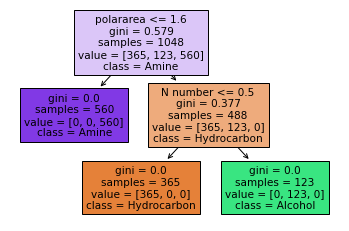

In [26]:
y_pred_dt = fit_predict(model['model_dt'], trainX, trainY, testX)

fig = plt.figure()
_ = tree.plot_tree(model['model_dt'], 
                   feature_names=trainX.columns,  
                   class_names=trainY.unique(),
                   filled=True)

sk_eval(testY, y_pred_dt)

# SMOTE Decision Tree

Classification report:
              precision    recall  f1-score   support

     Alcohol       1.00      1.00      1.00       249
       Amine       1.00      1.00      1.00        60
 Hydrocarbon       1.00      1.00      1.00       391

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

-------------------------
Accuracy Score: 1.0
-------------------------
Confusion Matrix:


array([[249,   0,   0],
       [  0,  60,   0],
       [  0,   0, 391]], dtype=int64)

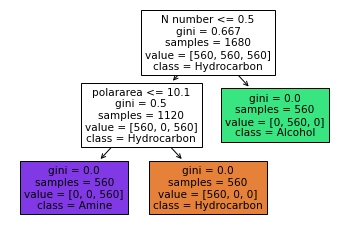

In [27]:
y_pred_dt_sm = fit_predict(model['model_dt'], trainX_sm, trainY_sm, testX)

fig = plt.figure()
_ = tree.plot_tree(model['model_dt'], 
                   feature_names=trainX.columns,  
                   class_names=trainY.unique(),
                   filled=True)

sk_eval(testY, y_pred_dt_sm)

# One vs All BLR - i.e. three models

## Binary Logistical Regression - Alc v All

In [28]:
#choose features, and construct trial eq
features_all = mol[['BoilingPoint', 'mw','polararea','heavycnt','hbondacc','C number','N number','O number','Side chain number','Double bond number','Triple bond number']]
trial_eq_features_all = 'BoilingPoint+mw+polararea+heavycnt+hbondacc+Q("C number")+Q("N number")+Q("O number")+Q("Side chain number")+Q("Double bond number")+Q("Triple bond number")'  

features = mol[['BoilingPoint']]
trial_eq_features = 'BoilingPoint'

In [29]:
#First Binary identifier
mol['mol_binary_alc'] = np.where(mol['O number'] > 0, 1, 0)

In [30]:
model = blr_fit(binary = 'mol_binary_alc', features=features, trial_eq_features=trial_eq_features)
model_alc = model[0]
model_alc_sm = model[1]
test_data_alc = model[2]

Optimization terminated successfully.
         Current function value: 0.640790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685070
         Iterations 5


In [31]:
model_alc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         mol_binary_alc   No. Observations:                 1048
Model:                          Logit   Df Residuals:                     1046
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:                0.008643
Time:                        20:39:54   Log-Likelihood:                -671.55
converged:                       True   LL-Null:                       -677.40
Covariance Type:            nonrobust   LLR p-value:                 0.0006217
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.4223      0.244     -5.820      0.000      -1.901      -0.943
BoilingPoint     0.0016      0.000      3.393      0.001       0.001       0.003
================================================================================
"""

In [32]:
blr_eval(model_alc_sm, test_data_alc, binary = 'mol_binary_alc')

Intercept       0.360008
BoilingPoint    1.002114
dtype: float64
-----------------
Accuracy score: 0.6528571428571428
-----------------
f1-score: 0.5050916496945009
----------------
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       451
           1       0.51      0.50      0.51       249

    accuracy                           0.65       700
   macro avg       0.62      0.62      0.62       700
weighted avg       0.65      0.65      0.65       700

-------------------------
Confusion Matrix:


array([[333, 118],
       [125, 124]], dtype=int64)

## Binary Logistic Regression - Amine v All

In [33]:
#Second Binary identifier
mol['mol_binary_amine'] = np.where(mol['N number'] > 0, 1, 0)

In [34]:
model = blr_fit(binary = 'mol_binary_amine', features=features, trial_eq_features=trial_eq_features)
model_amine = model[0]
model_amine_sm = model[1]
test_data_amine = model[2]

Optimization terminated successfully.
         Current function value: 0.360733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689764
         Iterations 4


In [35]:
model_amine.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       mol_binary_amine   No. Observations:                 1048
Model:                          Logit   Df Residuals:                     1046
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:                0.002521
Time:                        20:39:54   Log-Likelihood:                -378.05
converged:                       True   LL-Null:                       -379.00
Covariance Type:            nonrobust   LLR p-value:                    0.1669
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.5028      0.395     -3.806      0.000      -2.277      -0.729
BoilingPoint    -0.0011      0.001     -1.326      0.185      -0.003       0.001
================================================================================
"""

In [36]:
blr_eval(model_amine_sm, test_data_amine, binary='mol_binary_amine')

Intercept       1.807334
BoilingPoint    0.998742
dtype: float64
-----------------
Accuracy score: 0.45
-----------------
f1-score: 0.1928721174004193
----------------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58       640
           1       0.11      0.77      0.19        60

    accuracy                           0.45       700
   macro avg       0.53      0.59      0.39       700
weighted avg       0.88      0.45      0.55       700

-------------------------
Confusion Matrix:


array([[269, 371],
       [ 14,  46]], dtype=int64)

## Binary Logistic Regression - Hydrocarbon v All

In [37]:
#Third Binary Identifier
mol['mol_binary_hc'] = np.where((mol['O number'] == 0) & (mol['N number'] == 0), 1, 0)

In [38]:
model = blr_fit(binary = 'mol_binary_hc', features=features, trial_eq_features=trial_eq_features)
model_hc = model[0]
model_hc_sm = model[1]
test_data_hc = model[2]

Optimization terminated successfully.
         Current function value: 0.687890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 4


In [39]:
model_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          mol_binary_hc   No. Observations:                 1048
Model:                          Logit   Df Residuals:                     1046
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:                0.004191
Time:                        20:39:54   Log-Likelihood:                -720.91
converged:                       True   LL-Null:                       -723.94
Covariance Type:            nonrobust   LLR p-value:                   0.01377
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6955      0.237      2.929      0.003       0.230       1.161
BoilingPoint    -0.0012      0.000     -2.432      0.015      -0.002      -0.000
================================================================================
"""

In [40]:
blr_eval(model_hc_sm, test_data_hc, binary='mol_binary_hc')

Intercept       1.685929
BoilingPoint    0.998911
dtype: float64
-----------------
Accuracy score: 0.5928571428571429
-----------------
f1-score: 0.6611177170035671
----------------
Classification report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       309
           1       0.62      0.71      0.66       391

    accuracy                           0.59       700
   macro avg       0.58      0.58      0.58       700
weighted avg       0.59      0.59      0.59       700

-------------------------
Confusion Matrix:


array([[137, 172],
       [113, 278]], dtype=int64)

In [41]:
f1_alc = blr_eval(model_alc, test_data_alc, binary='mol_binary_alc', f1_only=True)
f1_amine = blr_eval(model_amine, test_data_amine, binary='mol_binary_amine', f1_only=True)
f1_hc = blr_eval(model_hc, test_data_hc, binary='mol_binary_hc', f1_only=True)


f1_alc_sm = blr_eval(model_alc_sm, test_data_alc, binary='mol_binary_alc', f1_only=True)
f1_amine_sm = blr_eval(model_amine_sm, test_data_amine, binary='mol_binary_amine', f1_only=True)
f1_hc_sm = blr_eval(model_hc_sm, test_data_hc, binary='mol_binary_hc', f1_only=True)

In [42]:
print(f'INPUT vars for one vs all blr: {trial_eq_features}')
print(f'f1 score alc: {f1_alc :.3f}')
print(f'f1 score amine: {f1_amine :.3f}')
print(f'f1 score hydrocarbon: {f1_hc :.3f}')

print('-----------------')
print(f'INPUT vars for one vs all blr: {trial_eq_features}')
print(f'smote f1 score alc: {f1_alc_sm :.3f}')
print(f'smote f1 score amine: {f1_amine_sm :.3f}')
print(f'smote f1 score hydrocarbon: {f1_hc_sm :.3f}')

INPUT vars for one vs all blr: BoilingPoint
f1 score alc: 0.015
f1 score amine: 0.000
f1 score hydrocarbon: 0.702
-----------------
INPUT vars for one vs all blr: BoilingPoint
smote f1 score alc: 0.505
smote f1 score amine: 0.193
smote f1 score hydrocarbon: 0.661


----------------------